In [85]:
import numpy as np
import time as time

In [136]:
import tkinter
import customtkinter
from tkinter import *
from tkinter.filedialog import askopenfilename
from PIL import Image, ImageTk
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [120]:
model = models.vgg19(pretrained=True).features

In [121]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [127]:

class VGG(nn.Module):
    def __init__(self): 
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']  # Indices for layers to extract
        self.model = models.vgg19(weights='DEFAULT').features[:29]  # Use 'weights' instead of 'pretrained'

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features


In [128]:
from PIL import Image
def load_image(image_name):
    image = Image.open(image_name)  # Make sure to use Image.open from PIL
    image = transform(image).unsqueeze(0)  # Apply your transformations
    return image.to(device) 

device=torch.device("cuda"if torch.cuda.is_available else"cpu")
image_size=256
# Define the transformation
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL Image
    transforms.Resize((256, 256)),  # Resize to desired dimensions
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Lambda(lambda x: x[:3, :, :])  # Take only the first 3 channels (RGB)
])




In [130]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to the desired size
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :])  # Keep only the first 3 channels (RGB)
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image

# Load images using the load_image function
original = load_image("C:/Users/Dareen/OneDrive/Pictures/Saved Pictures/IMG_4457.PNG")
style = load_image("C:/Users/Dareen/OneDrive/Pictures/Saved Pictures/b1047cae49f62bf3b90b5271c6f798c3.jpg")
generated = original.clone().requires_grad_(True)

# Initialize VGG model
model = VGG().to(device=device).eval()


In [131]:
total_steps=6000
learning_rate=0.001
alpha=1
beta=0.01
optimizer = optim.Adam([generated],lr=learning_rate)

In [132]:

model=VGG().to(device=device).eval()
for step in range(total_steps):
    generated_features = model(generated)
    original_features = model(original)
    style_features = model(style)

    style_loss = original_loss = 0
    for generated_feature, original_feature, style_feature in zip(generated_features, original_features, style_features):
        batch_size, channel, height, width = generated_feature.shape

        # Calculate original loss
        original_loss += torch.mean((generated_feature - original_feature) ** 2)

        # Gram matrix for generated feature
        g = generated_feature.view(channel, height * width).mm(generated_feature.view(channel, height * width).t())
        # Gram matrix for style feature
        a = style_feature.view(channel, height * width).mm(style_feature.view(channel, height * width).t())

        # Calculate style loss
        style_loss += torch.mean((g - a) ** 2)

    # Total loss
    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(f"Step: {step}, Total Loss: {total_loss.item()}")
        save_image(generated, f"generated_{step}.png")


Step: 0, Total Loss: 92124.8671875
Step: 200, Total Loss: 4019.328125
Step: 400, Total Loss: 2341.264892578125
Step: 600, Total Loss: 1690.5050048828125
Step: 800, Total Loss: 1363.637939453125
Step: 1000, Total Loss: 1169.2567138671875
Step: 1200, Total Loss: 1028.508544921875
Step: 1400, Total Loss: 916.9267578125
Step: 1600, Total Loss: 825.5308227539062
Step: 1800, Total Loss: 748.4448852539062
Step: 2000, Total Loss: 681.8803100585938
Step: 2200, Total Loss: 623.8902587890625
Step: 2400, Total Loss: 572.9170532226562
Step: 2600, Total Loss: 528.1154174804688
Step: 2800, Total Loss: 488.5142517089844
Step: 3000, Total Loss: 453.1982727050781
Step: 3200, Total Loss: 421.5133361816406
Step: 3400, Total Loss: 392.62713623046875
Step: 3600, Total Loss: 366.26324462890625
Step: 3800, Total Loss: 342.17138671875
Step: 4000, Total Loss: 320.07281494140625
Step: 4200, Total Loss: 299.5806579589844
Step: 4400, Total Loss: 280.5372619628906
Step: 4600, Total Loss: 262.9674377441406
Step: 480

In [133]:
generated

tensor([[[[ 0.0477,  0.1933,  0.1586,  ...,  0.3686,  0.4663,  0.3920],
          [-0.0421,  0.1855,  0.1261,  ...,  0.2797,  0.2241,  0.0876],
          [ 0.2601,  0.4240,  0.2441,  ...,  0.5373,  0.4175,  0.2553],
          ...,
          [ 0.4608,  0.4177,  0.2511,  ...,  0.5996,  0.1719,  0.3564],
          [ 0.3208,  0.6105,  0.5133,  ...,  0.3699,  0.3028,  0.3212],
          [-0.0286,  0.1597,  0.4132,  ...,  0.3707,  0.3927,  0.1435]],

         [[ 0.2905,  0.1546,  0.2965,  ...,  0.2574,  0.1932,  0.0424],
          [ 0.3045,  0.2400,  0.3948,  ...,  0.3994,  0.3164,  0.4767],
          [ 0.1109,  0.1098,  0.3277,  ...,  0.2983,  0.3148,  0.2788],
          ...,
          [ 0.4178,  0.4124,  0.5311,  ...,  0.3201,  0.2772,  0.3964],
          [ 0.4436,  0.3449,  0.4134,  ...,  0.3873,  0.2732,  0.2273],
          [ 0.5816,  0.2783,  0.5359,  ...,  0.4803,  0.3361,  0.2329]],

         [[-0.0489,  0.2308,  0.1754,  ...,  0.2587,  0.1407,  0.1918],
          [ 0.2365,  0.1755,  

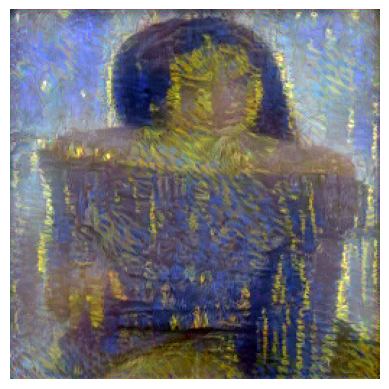

In [135]:
import matplotlib.pyplot as plt

# Assuming 'generated' is your image tensor
# Convert the tensor to a NumPy array
def display_image(tensor):
    tensor = tensor.detach().cpu()  # Move tensor to CPU and detach from graph
    image = tensor.numpy()  # Convert to NumPy array
    image = image.squeeze(0)  # Remove the batch dimension
    image = image.transpose(1, 2, 0)  # Change shape from C x H x W to H x W x C
    image = np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1]
    
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Call the function with the generated tensor
display_image(generated)
